# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 8)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)

scheduler_init_fn = get_cosine_schedule_with_warmup()
# Use mixup in SSL training, Use UDA maybe


In [2]:
import random
def get_preprocess_text():
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/fdab.csv")
    def process(text, **kwargs):
        text = translation(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def text_vec(texts, ids):
    return [preprocess_text(text, identifier=identifier) for text, identifier in zip(texts, ids)]

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view_1():
        
        imtrans = image_views[0]
        def vip(images):
            return [imtrans(i) for i in images]

        def aug(sampleList):
            sampleList = dict2sampleList(sampleList, device=get_device())
            sampleList = sampleList.copy()
            sampleList.image = vip(sampleList.original_image)
            sampleList.text = text_vec(sampleList.original_text, sampleList.id)
            sampleList.mixup = [False] * len(sampleList.text)
            sampleList = sampleList.to(get_device())
            return sampleList
        return aug
    
    return [get_view_1()]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=None,
                    train_image_transform=None,
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)





In [3]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.4, 0.5], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.4, 0.5], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_twitter": 0.75,"word_cutout": 0.5,
                      "one_third_cut": 0.2, "half_cut":0.0, "part_select": 0.2, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/fdab.csv")
    def process(text, **kwargs):
        if random.random() < 0.25:
            text = sentence_level(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        text = word_level(text, **kwargs)
        text = char_level(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def text_vec(texts, ids):
    return [preprocess_text(text, identifier=identifier) for text, identifier in zip(texts, ids)]

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view_1():
        
        imtrans = image_views[0]
        def vip(images):
            return [imtrans(i) for i in images]

        def aug(sampleList):
            sampleList = dict2sampleList(sampleList, device=get_device())
            sampleList = sampleList.copy()
            sampleList.image = vip(sampleList.original_image)
            sampleList.text = text_vec(sampleList.original_text, sampleList.id)
            sampleList.mixup = [False] * len(sampleList.text)
            sampleList = sampleList.to(get_device())
            return sampleList
        return aug
    
    return [get_view_1()]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)


data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
data['dev_unseen']["label"] = -1

df = pd.concat((data["train"],
                data['dev_unseen'],
                data["test"], data['test_unseen']))
df.shape



(12540, 4)

In [4]:
dataset = convert_dataframe_to_dataset(df, data["metadata"], True)

In [5]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.05, gaussian_noise=0.01), 
                "vilbert": dict(dropout=0.1, gaussian_noise=0.01), 
                "visual_bert": dict(dropout=0.1, gaussian_noise=0.01), 
                "mmbt_region": dict(dropout=0.05, gaussian_noise=0.01)},
    num_classes=2,
    gaussian_noise=0.0,
    dropout=0.0,
    word_masking_proba=0.125,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=0,
    bbox_copies=0,
    bbox_deletes=0,
    bbox_gaussian_noise=0.01,
    view_transforms=get_views(),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)
model = model.to(get_device())




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Overriding option config to projects/hateful_memes/configs/mmbt/with_features.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.features
Overriding option evaluation.predict to true


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


In [4]:
# torch.save(model.lxmert.state_dict(), "lxmert-mlm-init.pth")
# model.lxmert.load_state_dict(torch.load("lxmert-mlm-init.pth"))

# torch.save(model.mmbt_region.state_dict(), "mmbt_region-mlm-init.pth")
# model.mmbt_region.load_state_dict(torch.load("mmbt_region-mlm-init.pth"))


# Unimodal MLM

In [6]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None)
mlm_model = mlm_model.to(get_device())
# mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
mlm_model = mlm_model.to(get_device())


<All keys matched successfully>

In [16]:
# torch.save(mlm_model.state_dict(), "mlm-model-v2-view-1.pth")



In [ ]:

lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": False,},
        "visual_bert": {"finetune": False,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlms": {"finetune": True},
}
epochs = 1
batch_size = 6
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=12, plot=True,
                                     sampling_policy=None, class_weights=None)




Autocast =  True Epochs =  1 Divisor = 1 Examples = 12540 Batch Size =  6
Training Samples =  12540 Weighted Sampling =  False Num Batches =  2090 Accumulation steps =  12
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


FeatureExtractor : Loaded Model...
Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...


In [ ]:
# Validate
# Predict

In [11]:
clean_memory()

In [9]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

Counter({'called': 1405,
         'hit': 1134,
         'key_error': 175,
         're-compute': 270,
         'writes': 163,
         'read_exception': 477,
         'read_retries': 477,
         'read-return-none': 95,
         're-compute-cache-busy-no-write': 95,
         'write_exception': 120,
         'write_retries': 120})

Counter({'called': 1400,
         'hit': 1216,
         'key_error': 165,
         're-compute': 184,
         'writes': 164,
         'read_exception': 95,
         'read_retries': 95,
         'read-return-none': 19,
         're-compute-cache-busy-no-write': 19,
         'write_exception': 10,
         'write_retries': 10})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


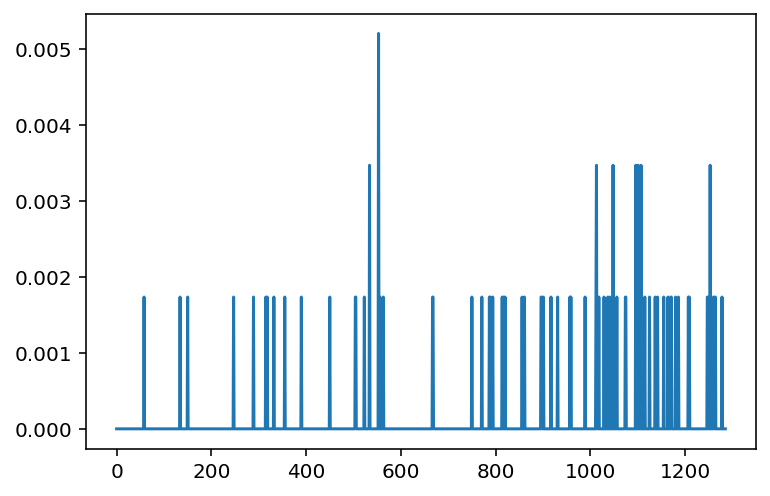

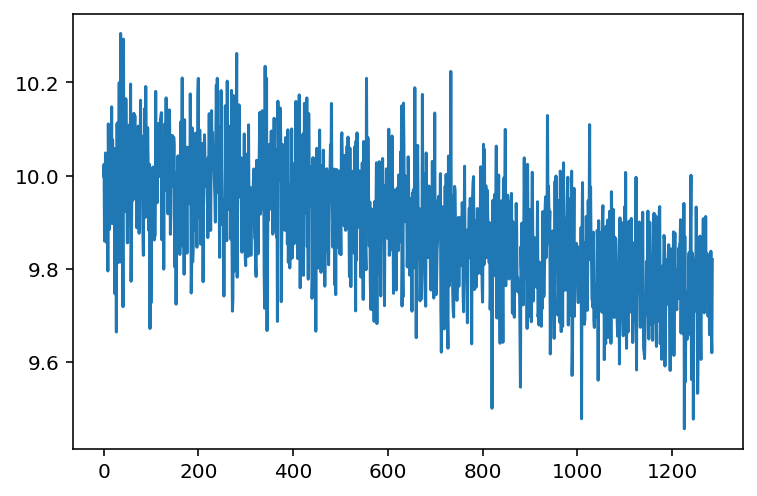

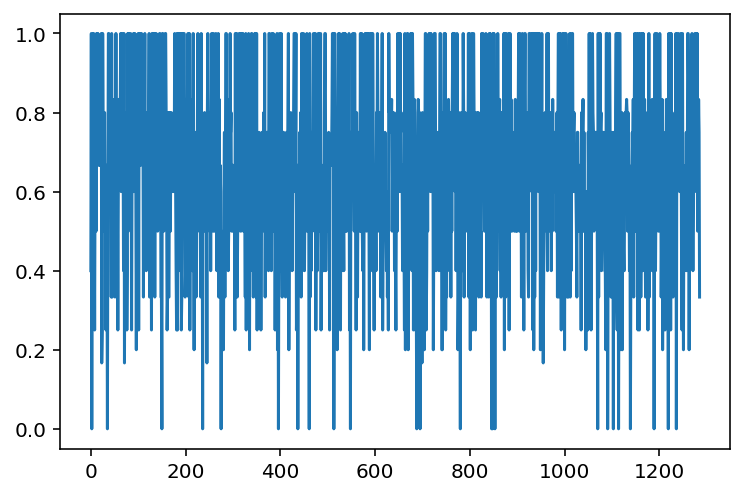

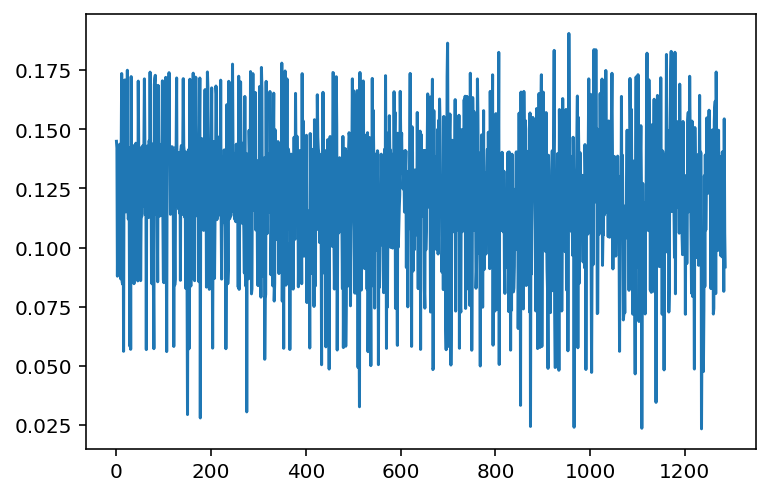

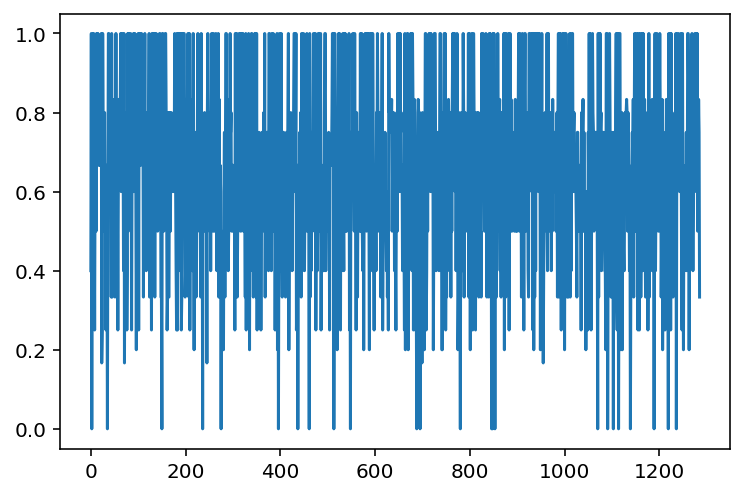

In [10]:
from matplotlib import pyplot as plt
plt.plot(mlm_model.mlm_accuracy_hist[4])
plt.show()
plt.plot(mlm_model.mlm_loss_hist[4])
plt.show()
plt.plot(mlm_model.target_accuracy_hist)
plt.show()

#

plt.plot(model.target_loss_hist)
plt.show()
plt.plot(model.target_accuracy_hist)
plt.show()


# Single Eval

## Validate

In [6]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...



Proba       Preds    
         min   max   min max
Labels                      
0      0.466 0.484     0   0
1      0.466 0.486     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.476,"[0.5243480205535889, 0.47565191984176636]",0,0,0.469,"[0.530956506729126, 0.4690435528755188]",0,1,0.480,"[0.5200297832489014, 0.479970246553421]",0,1
1,0.470,"[0.5303853154182434, 0.4696146845817566]",0,0,0.468,"[0.5315169095993042, 0.4684830904006958]",0,1,0.484,"[0.516499400138855, 0.48350057005882263]",0,0
2,0.475,"[0.5247277021408081, 0.4752722680568695]",0,0,0.482,"[0.5181204080581665, 0.4818796217441559]",0,1,0.480,"[0.5204855799674988, 0.47951436042785645]",0,0
3,0.470,"[0.5297280550003052, 0.4702719449996948]",0,0,0.469,"[0.5307703614234924, 0.46922963857650757]",0,0,0.480,"[0.5204127430915833, 0.47958722710609436]",0,1
4,0.477,"[0.5233438611030579, 0.47665607929229736]",0,1,0.476,"[0.5243939161300659, 0.4756060838699341]",0,1,0.478,"[0.5218499302864075, 0.4781500995159149]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,253,0.000,253.000,100.000
1,247,0.000,247.000,0.000
Predicted Counts,500,0.000,500.000,nan
Precision %,50,nan,nan,nan


scores =  {'map': '0.6903', 'acc': '0.5060', 'auc': '0.7140'}


([0.6903226344046449, 0.506, 0.7139748123729818],
 (array([0.506, 0.   ]),
  array([1., 0.]),
  array([0.67197875, 0.        ]),
  array([253, 247])))

In [6]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


FeatureExtractor : Loaded Model...
Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...



Proba       Preds    
         min   max   min max
Labels                      
0      0.466 0.484     0   0
1      0.466 0.485     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.474,"[0.5260858535766602, 0.4739142060279846]",0,0,0.468,"[0.5316855907440186, 0.46831443905830383]",0,0,0.475,"[0.5254419445991516, 0.47455811500549316]",0,1
1,0.470,"[0.53037029504776, 0.4696296453475952]",0,0,0.483,"[0.5173438787460327, 0.4826560616493225]",0,0,0.471,"[0.5287243723869324, 0.47127565741539]",0,0
2,0.472,"[0.5282604098320007, 0.4717395603656769]",0,0,0.473,"[0.526985228061676, 0.47301480174064636]",0,0,0.479,"[0.5212312936782837, 0.4787687063217163]",0,1
3,0.473,"[0.5274060964584351, 0.47259384393692017]",0,1,0.479,"[0.5210641026496887, 0.47893595695495605]",0,1,0.476,"[0.5241628289222717, 0.47583717107772827]",0,1
4,0.468,"[0.5316758751869202, 0.46832403540611267]",0,1,0.479,"[0.521003007888794, 0.47899705171585083]",0,1,0.478,"[0.5223824977874756, 0.4776175320148468]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,340,0.000,340.000,100.000
1,200,0.000,200.000,0.000
Predicted Counts,540,0.000,540.000,nan
Precision %,62,nan,nan,nan


scores =  {'map': '0.5523', 'acc': '0.6296', 'auc': '0.7078'}


([0.5523083679215276, 0.6296296296296297, 0.7078308823529411],
 (array([0.62962963, 0.        ]),
  array([1., 0.]),
  array([0.77272727, 0.        ]),
  array([340, 200])))

## Predict

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
